# Pytorch Custom Datasets

## Domain libraries

Depending on what you're working on, vision, test, audio. recommendation, you'll want to look into each of the PyTorch domain lobraries for existing data loading functions and customizable data loading functions

## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

torch.__version__

'2.2.1+cu121'

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.backends.mps.is_available() else device

device

'cpu'

## 1. Get Data

Our dataset is a subset of the Food101 dataset.

Food101 starts 101 different classes of fodd and 1000 images per class (750 training, 250 testing)

Out dataset starts with 3 classes of data and only 10% of the images (~75 training, ~25 testing)

Why do this?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necesaary.

The whole point is to speed up how fast you can experiment.

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it.
if image_path.is_dir():
    print(f"{image_path} directory already exists... skipping download")
else:
    print(f"{image_path} does not exist, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza steak and sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak and sushi data...")
        zip_ref.extractall(image_path)


data/pizza_steak_sushi does not exist, creating one...
Unzipping pizza, steak and sushi data...


## 2. Becoming one with the data (data preperation and data exploration)

In [4]:
import os

def walk_through_dir(dir_path):
    """Walks through dir_path returning its contents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.


In [6]:
# Setup train and test paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing and image

Let's write some code to:
1. Get all of the image paths
2. Pick a random image path using Python's `random.choice()`
3. Get the image class name `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python's PIL
5. We'll then show the image and print metadata

Random image path: data/pizza_steak_sushi/train/pizza/2493954.jpg
Image class: pizza
Image height: 512
Image width: 512


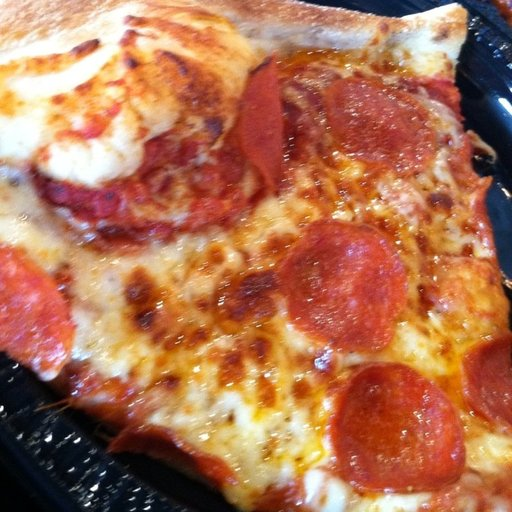

In [7]:
import random
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from the (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

Random image path: data/pizza_steak_sushi/train/steak/1787505.jpg
Image class: steak
Image height: 512
Image width: 512
Image shape: (512, 512, 3) - [height, width, color_channels]


(-0.5, 511.5, 511.5, -0.5)

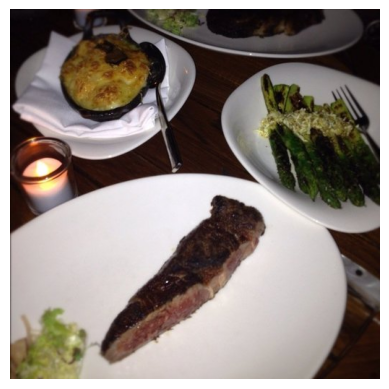

In [8]:
# Try to visualize and image with matplotlib...
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt

# Set seed
# random.seed(42)

# 1. Get all image path
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get the random image path
random_image_path = random.choice(image_path_list)

# 3. Get the image class
image_class = random_image_path.parent.stem

# 4. Load the image
img = Image.open(random_image_path)

# 5. Convert image from PIL to tensor
image_as_array = np.asarray(img)

# 6. Print the image and metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
print(f"Image shape: {image_as_array.shape} - [height, width, color_channels]")
plt.imshow(image_as_array, cmap="gray")
plt.axis(False)

## 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`.

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to be used with a model/perform data augmentation

In [10]:
# Write a transform for images
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [11]:
transform_image = data_transform(img)
transform_image.dtype

torch.float32

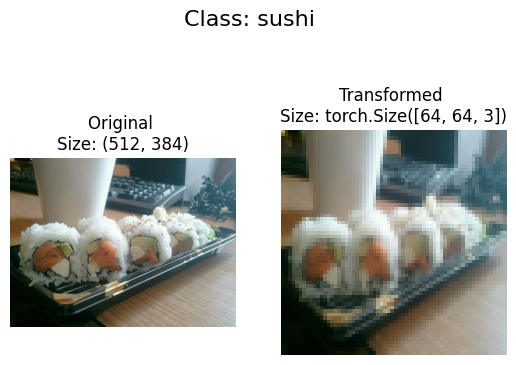

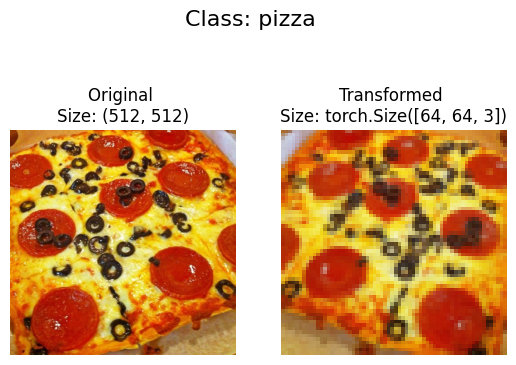

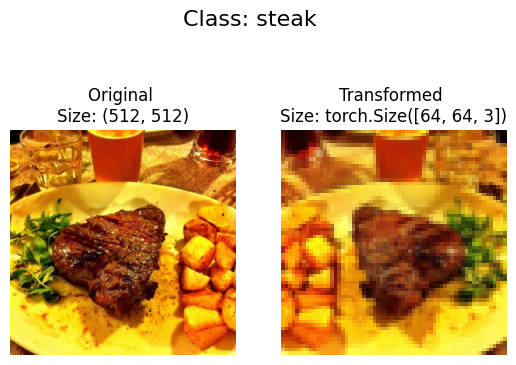

In [12]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
    """
    Selects random images from apth of images and loads/transforms them then plots the original vs transformed version.
    Plots a series of random images from image_paths.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`

In [13]:
# Use ImageFolder to creare dataset's
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [14]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [15]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [17]:
# Check the targets
train_data.targets[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [18]:
# Check the samples
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [19]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

In [20]:
class_names[label]

'pizza'

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

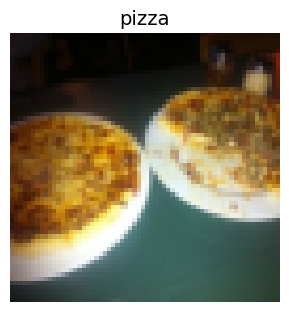

In [21]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(5, 3.5))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=14)

### 4.1 Turn loaded images into `DataLoader`'s

A `DataLoader` is going to help us turn our `Dataset`'s into a iterables and we can customize the batch_Size so our model can see `batch_size` images at a time

In [22]:
import os
os.cpu_count()

2

In [23]:
# Import the dataloader
import os
from torch.utils.data import DataLoader

# Set the batch size hyperparameter
BATCH_SIZE = 1

# Turn train and test datasets into DataLoader's
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a7038e475e0>,
 <torch.utils.data.dataloader.DataLoader at 0x7a7038e47ee0>)

In [24]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [25]:
len(train_dataloader.dataset), len(test_dataloader.dataset)

(225, 75)

In [26]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if you like
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 5. Option 2: Loading Image Data with a custon `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create. a `Dataset` out of almost anything
* Not limited to PyTorch pre=built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it doesn't mean it will work...
* Usinga custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues

> All custom datasets in PyTorch, often subclass - `torch.utils.data.Dataset`

In [27]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error is the class name aren't found (if this happens, there might be somthing wroing with the directory structure).
3. Turn the class names into a dict and a list and return them.

In [28]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [29]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the classes folder names in a target directory"""
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}... PLEASE CHECK FILE STRUCTURE")

    # 3. Create a dictionary of index labels (computers prefer nmbers rather thans strings as labels)
    class_to_idx = {class_name:ind for ind, class_name in enumerate(classes)}
    return classes, class_to_idx

In [30]:
class_names, class_to_idx = find_classes(target_directory)
class_names, class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to:

1. Subclass `torch.utisl.data.Dataset`
2. Init out subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transofmr our data.
3. Create several attributes:
    * paths - paths of our images
    * transform - the transform we'd like to use
    * classes - a list of the target classes
    * class_to_idx - a dict of the target classes mapped to integer
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len__` method to return the length of our dataset
6. Overwrite the `__getitem__` method to return a given sample when passed an index

In [31]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.Dataset
class ImageFolderCustom(Dataset):
    # 2. Initialize our custom dataset
    def __init__(self, targ_dir: str, transform=None):
        # 3. Create class attributes
        # Get all of the image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        # Setup transforms
        self.transform = transform
        # Create classes and class _to_index attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Create a function to load images
    def load_image(self, index: int) -> Image.Image:
        """Opena an image via a path and returns it."""
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overrite __len__()
    def __len__(self) -> int:
        """Returns the total number of samples."""
        return len(self.paths)

    # 6. Overrite the __getitem__() method to return a particular sample
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """Returns one sample of data, data and label (X, y)."""
        img = self.load_image(index)
        class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]

        # Transforms if necessary
        if self.transform:
            return self.transform(img), class_idx # return transformed data, label (X, y)
        else:
            return img, class_idx # return untransformed data, label (X, y)


In [32]:
# Create a transforms
from torchvision import transforms

# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data
test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [33]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7a7038ec3cd0>,
 <__main__.ImageFolderCustom at 0x7a7038ec2920>)

In [34]:
len(train_data), len(train_data_custom)

(225, 225)

In [35]:
len(test_data), len(test_data_custom)

(75, 75)

In [36]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [37]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

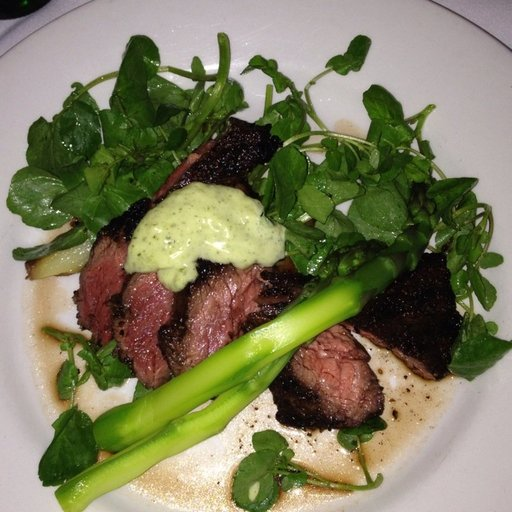

In [38]:
train_data_custom.load_image(10)

In [39]:
train_data_custom[10]

(tensor([[[0.5137, 0.5294, 0.5373,  ..., 0.0353, 0.0275, 0.0275],
          [0.5529, 0.5608, 0.5765,  ..., 0.0588, 0.0392, 0.0353],
          [0.5804, 0.5882, 0.5922,  ..., 0.3333, 0.3216, 0.3059],
          ...,
          [0.7569, 0.7608, 0.7686,  ..., 0.8078, 0.8000, 0.8000],
          [0.7569, 0.7608, 0.7686,  ..., 0.8039, 0.8039, 0.8000],
          [0.7529, 0.7569, 0.7647,  ..., 0.8039, 0.8078, 0.8039]],
 
         [[0.4706, 0.4863, 0.4941,  ..., 0.0667, 0.0275, 0.0275],
          [0.5059, 0.5137, 0.5255,  ..., 0.0588, 0.0353, 0.0353],
          [0.5294, 0.5373, 0.5451,  ..., 0.3176, 0.3059, 0.2863],
          ...,
          [0.7098, 0.7137, 0.7255,  ..., 0.7725, 0.7647, 0.7608],
          [0.7098, 0.7137, 0.7216,  ..., 0.7686, 0.7647, 0.7608],
          [0.7059, 0.7098, 0.7176,  ..., 0.7686, 0.7647, 0.7569]],
 
         [[0.5020, 0.5176, 0.5255,  ..., 0.0314, 0.0353, 0.0353],
          [0.5412, 0.5490, 0.5608,  ..., 0.0627, 0.0471, 0.0431],
          [0.5647, 0.5725, 0.5804,  ...,

In [40]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustom Dataset
print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a  `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility.
4. Get a list of random samples indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random indexes images and plot them with matplotlib.
7. Make sure the dimensions of our images line up with matplotlib (HWC)

In [41]:
from math import ceil

# 1. Create a function to take in a dataset.
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 5,
                          display_shape: bool = True,
                          seed: int = None):
    # 2. Adjust display if n is too high
    if n > 10:
        n = 10
        # display_shape = False
        print(f"For display purposes, n should'ny be larger than 10, setting to 10")

    # 3. Set the seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup a matplotlib plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through random indexes and plot them with matplotlib
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust tensor dimensions for plotting
        targ_image_adjust = targ_image.permute(1, 2, 0) # [color_channels, height, width] -> [height, width, color_channels]

        # Plot adjusted samples
        plt.subplot(2, 5, i + 1)
        plt.imshow(targ_image_adjust)
        plt.axis(False)
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nShape: {targ_image_adjust.shape}"
            plt.title(title)

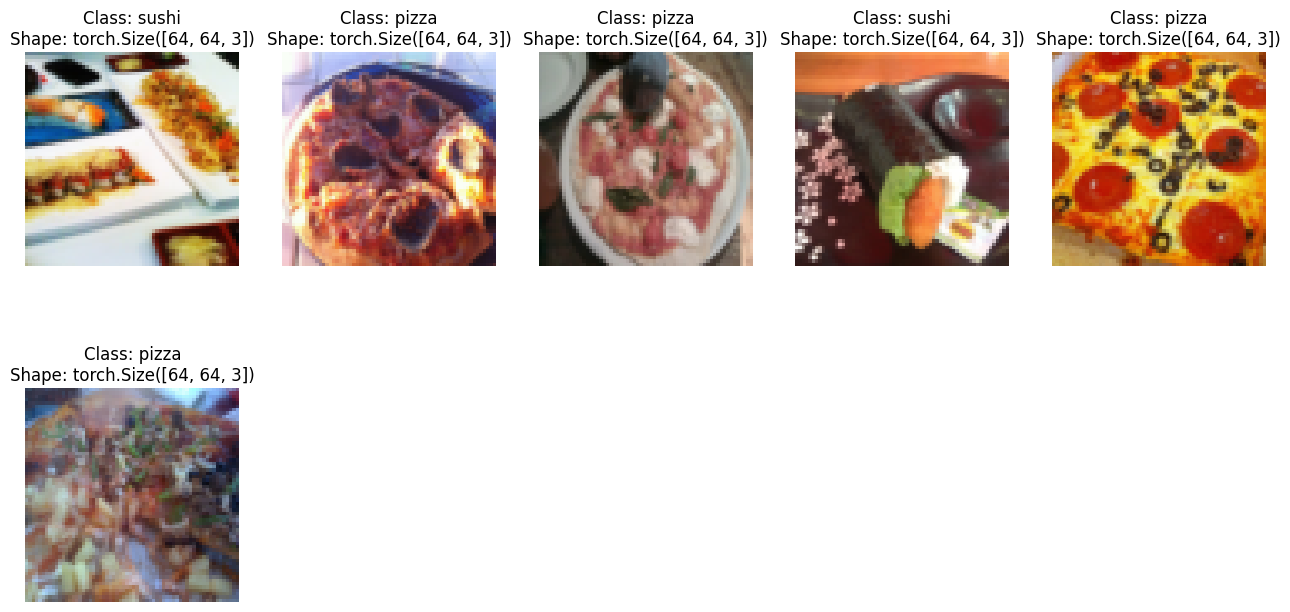

In [42]:
# Display random images from the ImageFolder Datase
display_random_images(dataset=train_data,
                      classes=class_names,
                      n=6,
                      display_shape=True,
                      seed=42)

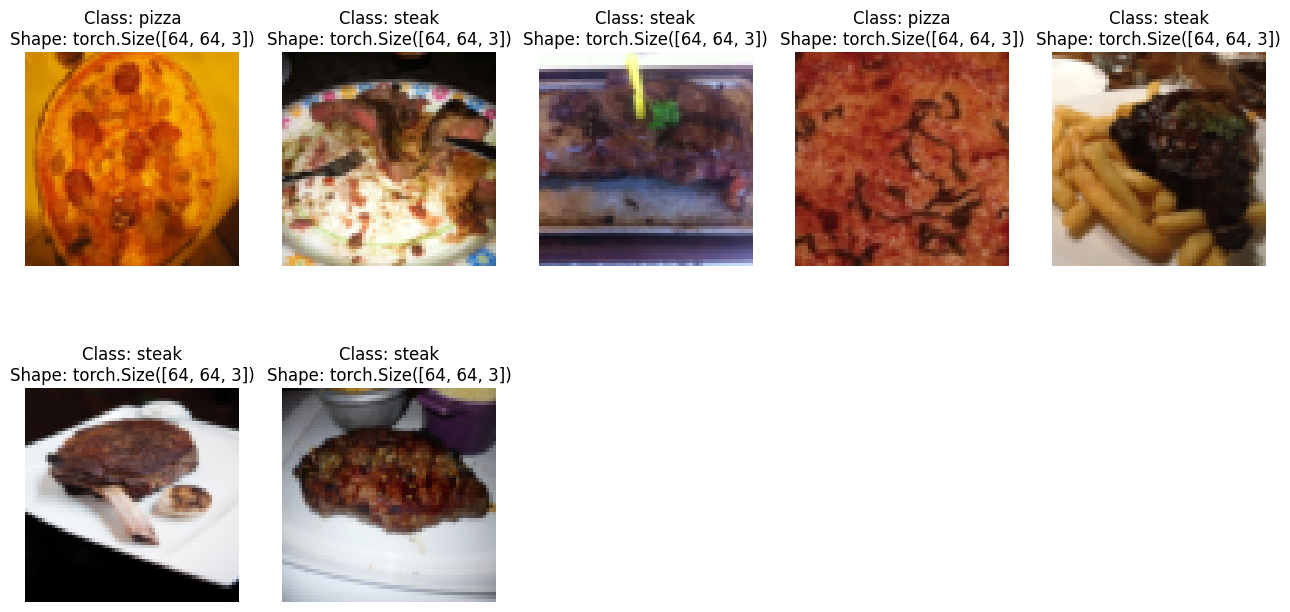

In [43]:
# Display random images from the ImageFoldeCustom Dataset
display_random_images(dataset=train_data_custom,
                      classes=train_data_custom.classes,
                      n=7,
                      display_shape=True,
                      seed=42)

### 5.4 Turn custom loaded images into `DataLoader`'s

In [44]:
# Get the cpu counts available
import os
NUM_WORKERS = os.cpu_count()
print(f"CPU cores available in this machine: {NUM_WORKERS}")

# Import DataLoader from torch
from torch.utils.data import DataLoader

# Set the batch size hyperparameter
BATCH_SIZE = 32

# Turn ImageFolderCustom dataset into train and test dataloader's
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_custom, test_dataloader_custom

CPU cores available in this machine: 2


(<torch.utils.data.dataloader.DataLoader at 0x7a703832eb90>,
 <torch.utils.data.dataloader.DataLoader at 0x7a7038f282e0>)

In [45]:
len(train_dataloader_custom), len(test_dataloader_custom)

(8, 3)

In [46]:
# Get image and label from custom dataloader
image_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shape
print(f"Image custom shape: {image_custom.shape}")
print(f"Label custom shape: {label_custom.shape}")

Image custom shape: torch.Size([32, 3, 64, 64])
Label custom shape: torch.Size([32])


## 6. Other forms of transforms (Data Augmentation)

Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may meen applying various image transformations to the training images.

This practice hoepfully results in a model that's more generalizable to unseen data.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels...

In [47]:
# Let's look at Trivial Augment
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

train_transform, test_transform

(Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
     TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
     ToTensor()
 ),
 Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
 ))

In [48]:
# Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/steak/1413972.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1966300.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2979061.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1937872.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2013535.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/443210.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1839481.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2628106.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/3857508.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/100135.jpg')]

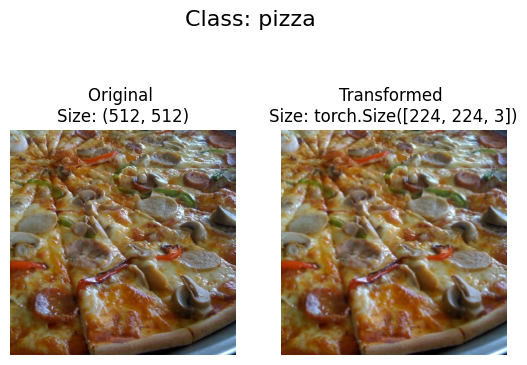

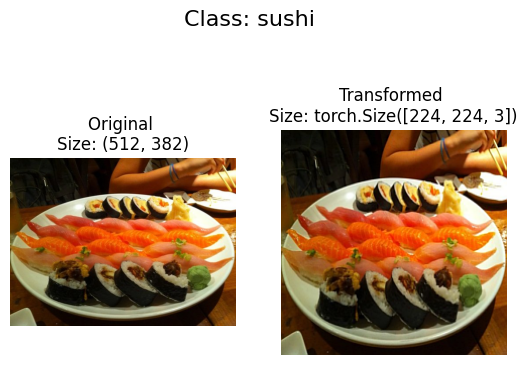

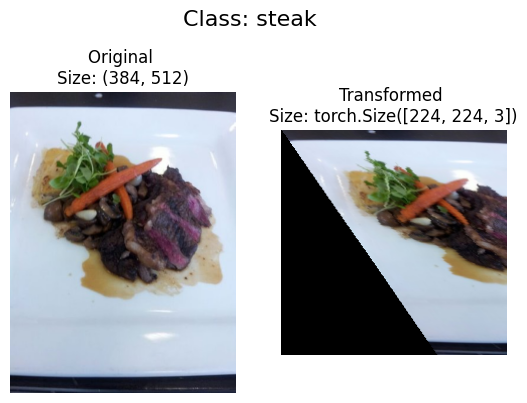

In [49]:
# Plot random transform images
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transform,
                        n=3,
                        seed=None)

## 7. Model 0: TinyVGG without data augmentation

### 7.1 Creating some transform and loading data for Model 0

In [50]:
from torchvision import transforms
from torchvision.datasets import ImageFolder

# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [51]:
# 1. Load and transform data
# Turn the data into dataset using torchvision ImageFolder
train_data_simple = ImageFolder(root=train_dir,
                         transform=simple_transform)
test_data_simple = ImageFolder(root=train_dir,
                        transform=simple_transform)

train_data_simple, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [52]:
# 2. Turn the ImageFolder datasets into DataLoaders
from torch.utils.data import DataLoader

# Set the hyperparameters for DataLoader (Batch size and num workers)
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create the train and test Dataloader's
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

train_dataloader_simple, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x7a7039229cf0>,
 <torch.utils.data.dataloader.DataLoader at 0x7a7039229c30>)

In [53]:
# Import the torch nn module
import torch
from torch import nn

# Set the seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Create TinyVGG model class
class TinyVGG(nn.Module):
    """Model architecure copying TinyVGG from CNN Explainer"""
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        # Create the convolutional block 1
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernal_size for MaxPool2d
        )
        # Create the convolutional block 2
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernal_size for MaxPool2d
        )
        # Create the classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        # x = self.conv_block_1(x)
        # # print(x.shape)
        # x = self.conv_block_2(x)
        # # print(x.shape)
        # x = self.classifier(x)
        # # print(x.shape)
        # return x
        return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits from operator fusion

In [54]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels in our image data
                  hidden_units=10,
                  output_shape=len(train_data_simple.classes)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)

In [55]:
# Create some dummy data
dummy_data = torch.randn(size=(1, 3, 64, 64))

model_0(dummy_data.to(device))

tensor([[ 0.0216, -0.0143, -0.0036]], grad_fn=<AddmmBackward0>)

In [56]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))

image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [57]:
# Try a forward pass
image_batch = image_batch.to(device)
model_0(image_batch)

tensor([[ 2.4284e-02, -4.2103e-03,  9.1338e-03],
        [ 2.0510e-02, -7.8605e-04,  8.4660e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2792e-02, -2.7526e-03,  1.1189e-02],
        [ 1.8338e-02,  1.6958e-04,  6.0050e-03],
        [ 2.1927e-02, -1.7779e-03,  8.1963e-03],
        [ 2.2926e-02, -1.4961e-03,  1.0282e-02],
        [ 2.0046e-02,  4.5709e-04,  1.0549e-02],
        [ 2.0898e-02,  1.3278e-04,  8.8580e-03],
        [ 1.9509e-02,  7.8302e-04,  8.2038e-03],
        [ 1.9482e-02, -2.1679e-03,  9.9535e-03],
        [ 1.9283e-02, -5.5838e-03,  1.2924e-02],
        [ 2.0974e-02, -4.5353e-03,  8.4500e-03],
        [ 2.2059e-02, -4.6367e-03,  1.2652e-02],
        [ 2.0804e-02,  1.9376e-04,  9.1865e-03],
        [ 2.1532e-02, -6.0486e-04,  7.3696e-03],
        [ 2.4643e-02, -3.2281e-03,  8.6759e-03],
        [ 1.9826e-02, -3.8645e-03,  9.8465e-03],
        [ 2.1256e-02, -1.6102e-03,  9.5531e-03],
        [ 1.8828e-02, -4.1589e-04,  8.5030e-03],
        [ 2.1695e-02

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [58]:
# Install torchinfo, import if it's available
try:
    import torchinfo
except:
    !pip install -q torchinfo

In [59]:
from torchinfo import summary

summary(model_0, input_size=(1, 3, 64, 64)) # do a test pass through of an example input size (shape of the image)

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Writing traing and testing functions

* `train.step()` - takes in a model and dataloader and trains the model on the dataloader.
* `test.step()` - takes in a model and dataloader and evaluates the model on the dataloader.

In [60]:
from tqdm.auto import tqdm

# Set the seed
torch.manual_seed(42)

# Set the hyperparameters
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [61]:
# Training loop
def train_step(model: torch.nn.Module,
                  data_loader: torch.utils.data.DataLoader,
                  loss_fn: torch.nn.Module,
                  optimizer: torch.optim.Optimizer,
                  device: torch.device=device) -> Tuple[int, int]:
    """Method to train the model looping over data loader"""
    # Set the model for train
    model.train()

    # Accumulate the train loss and accuracy
    train_loss, train_acc = 0, 0

    # Looping over data loader
    for i, (X, y) in enumerate(data_loader):
        # Put data to the target device
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X) # outputs model logits

        # Calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Calculate the accuracy
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        accuracy = (y_pred_class == y).sum().item() / len(y_pred)
        train_acc += accuracy

        # Optmizer zero grad
        optimizer.zero_grad()

        # Backward propagation
        loss.backward()

        # Gradient descent
        optimizer.step()

    # Calculate the average loss per batch
    train_loss /= len(data_loader)

    # Calculate the average the accuracy per batch
    train_acc /= len(data_loader)

    return train_loss, train_acc

In [62]:
# Testing loop
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device=device) -> Tuple[int, int]:
    """Method to test the nodel looping over data loader"""
    # Set the model for evaluation
    model.eval()

    # Accumulate the test loss and accuracy
    test_loss, test_acc = 0, 0

    # Turn on inference mode
    with torch.inference_mode():
        # Looping over data loader
        for X, y in data_loader:
            # Put the data to the target device
            X, y = X.to(device), y.to(device)

            # Forward pass
            test_pred = model(X)

            # Calculate the loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            # Calculate the accuracy
            test_pred_class = torch.argmax(torch.softmax(test_pred, dim=1), dim=1)
            accuracy = (test_pred_class == y).sum().item() / len(test_pred)
            test_acc += accuracy

    # Calculate the average loss per batch
    test_loss /= len(data_loader)

    # Calculate the average accuracy per batch
    test_acc /= len(data_loader)

    return test_loss, test_acc

### 7.6 Creating `train()` function to compine `train_step()` and `test_step()`

In [63]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Calculate the time taken for the training process
from timeit import default_timer as timer

# Create the train function
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int=5,
          device: torch.device=device) -> dict:
    # Create emtpy results dictionary
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # Start the timer
    start_timer = timer()

    # Loop over train and test function for model training
    for epoch in tqdm(range(epochs)):
        # Train the model
        train_loss, train_acc = train_step(model=model,
                                           data_loader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)

        # Test the model
        test_loss, test_acc = test_step(model=model,
                                        data_loader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out the metrics after each epoch
        print(
            f"Epoch: {epoch + 1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update the results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # End the timer
    end_timer = timer()

    # Time taken
    time_taken = end_timer - start_timer

    # Print out the time taken for training and testing cycle
    print(f"\nTime taken to train the model: {time_taken:.3f}\n")

    # Return the results dictionary after all the epochs
    return results

### 7.7 Train and evaluate the `model_0`

In [64]:
# Set the seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 50

# Create the instance of TinyVGG
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                            lr=0.001)

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS,
                        device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1063 | train_acc: 0.3047 | test_loss: 1.0956 | test_acc: 0.4492
Epoch: 2 | train_loss: 1.0998 | train_acc: 0.3281 | test_loss: 1.0830 | test_acc: 0.4023
Epoch: 3 | train_loss: 1.0869 | train_acc: 0.4883 | test_loss: 1.0797 | test_acc: 0.4336
Epoch: 4 | train_loss: 1.0842 | train_acc: 0.3984 | test_loss: 1.0572 | test_acc: 0.5469
Epoch: 5 | train_loss: 1.0662 | train_acc: 0.4141 | test_loss: 1.0395 | test_acc: 0.4453
Epoch: 6 | train_loss: 1.0305 | train_acc: 0.4336 | test_loss: 0.9835 | test_acc: 0.5469
Epoch: 7 | train_loss: 0.9854 | train_acc: 0.4219 | test_loss: 0.9170 | test_acc: 0.5273
Epoch: 8 | train_loss: 0.9663 | train_acc: 0.5781 | test_loss: 0.8881 | test_acc: 0.5273
Epoch: 9 | train_loss: 0.9238 | train_acc: 0.5977 | test_loss: 0.8909 | test_acc: 0.4961
Epoch: 10 | train_loss: 0.9969 | train_acc: 0.4648 | test_loss: 0.8761 | test_acc: 0.6016
Epoch: 11 | train_loss: 0.8699 | train_acc: 0.5195 | test_loss: 0.8434 | test_acc: 0.6406
Epoch: 12 | train_l

In [65]:
model_0_results

{'train_loss': [1.106319084763527,
  1.0998057276010513,
  1.0868544578552246,
  1.0842333137989044,
  1.0662163347005844,
  1.0305050686001778,
  0.9854370653629303,
  0.9662912264466286,
  0.9238169267773628,
  0.9969005659222603,
  0.8698794320225716,
  0.9240578711032867,
  0.7841039318591356,
  0.9045028984546661,
  0.789142481982708,
  0.7492810562252998,
  0.7733712382614613,
  0.7480174712836742,
  0.7749622315168381,
  0.7755447328090668,
  0.7844467312097549,
  0.7869665324687958,
  0.7322786599397659,
  0.8699127808213234,
  0.6531565133482218,
  0.7044287100434303,
  0.6315567307174206,
  0.6560348756611347,
  0.6014471943490207,
  0.7655341327190399,
  0.6606595367193222,
  0.5743622509762645,
  0.5757075883448124,
  0.5709167383611202,
  0.5547012519091368,
  0.5703363064676523,
  0.5946025587618351,
  0.6467064097523689,
  0.672199510037899,
  0.5825753547251225,
  0.7023898549377918,
  0.6265740841627121,
  0.6582956910133362,
  0.6485462933778763,
  0.7044902220368385,

### 7.8 Plot the loss curves of `model_0`

A **loss curve** is a way of tracking your model's progress over time.

In [66]:
# Get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [67]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary."""
    # Get the loss values of the results dictionary (training and test)
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    # Figure our how many epochs there were
    epochs = range(len(loss))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    # plt.ylabel("Loss")
    plt.legend()

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    # plt.ylabel("Accuracy")
    plt.legend()

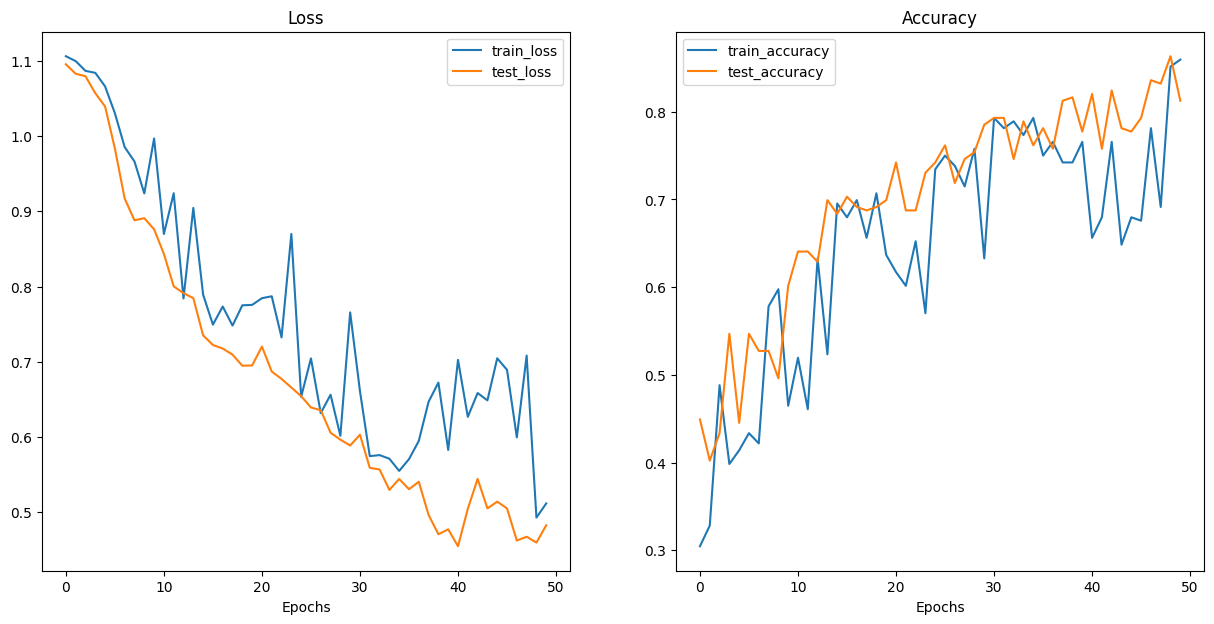

In [68]:
plot_loss_curves(model_0_results)

## 8. What should be an ideal loss curve look like?

A loss curve is one of the most helpful ways to troubleshoot a model.

## 9. Model 1: TinyVGG with Data Augmentation

Now let's try another modelling experiment this time using the same model as before with some data augmentation.

### 9.1 Create transform with data augmentation

In [69]:
# Create the train and test transform with Trivial Augment
from torchvision import transforms

train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

train_transform_trivial, test_transform_simple

(Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
     TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
     ToTensor()
 ),
 Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
 ))

### 9.2 Create train and test `Dataset`'s and `DataLoader`'s with data augmentation

In [70]:
# Turn image folders into Datasets
from torchvision.datasets import ImageFolder

# Create the train dataset
train_dataset_trivial = ImageFolder(root=train_dir,
                            transform=train_transform_trivial)

# Create the test dataset
test_dataset_simple = ImageFolder(root=test_dir,
                                   transform=test_transform_simple)

train_dataset_trivial, test_dataset_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [71]:
# Turn datasets into DataLoaders
import os
from torch.utils.data import DataLoader

# Set the dataloader hyper parameters
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create the train dataloader
train_dataloader_augmented = DataLoader(dataset=train_dataset_trivial,
                                      batch_size=BATCH_SIZE,
                                      num_workers=NUM_WORKERS,
                                      shuffle=True)

# Create the test dataloader
test_dataloader_simple = DataLoader(dataset=test_dataset_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=False)

train_dataloader_augmented, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x7a703832e140>,
 <torch.utils.data.dataloader.DataLoader at 0x7a703832d180>)

In [72]:
len(train_dataloader_augmented), len(test_dataloader_simple), len(train_dataloader_augmented.dataset), len(test_dataloader_simple.dataset)

(8, 3, 225, 75)

### 9.3 Construct and train model 1

This time we'll be using the same model architecure except this time we've augmented the training data.

In [73]:
from torch import nn

# Set the seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 50

# Create the instance of TinyVGG
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_dataset_trivial.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

# Train the model
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS,
                        device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1069 | train_acc: 0.3047 | test_loss: 1.0993 | test_acc: 0.2708
Epoch: 2 | train_loss: 1.1019 | train_acc: 0.3203 | test_loss: 1.0719 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.0917 | train_acc: 0.4375 | test_loss: 1.0846 | test_acc: 0.4924
Epoch: 4 | train_loss: 1.0915 | train_acc: 0.3125 | test_loss: 1.0678 | test_acc: 0.5833
Epoch: 5 | train_loss: 1.0862 | train_acc: 0.3594 | test_loss: 1.0751 | test_acc: 0.5331
Epoch: 6 | train_loss: 1.0675 | train_acc: 0.5234 | test_loss: 1.0446 | test_acc: 0.6042
Epoch: 7 | train_loss: 1.0762 | train_acc: 0.3477 | test_loss: 1.0023 | test_acc: 0.6146
Epoch: 8 | train_loss: 1.0878 | train_acc: 0.3477 | test_loss: 1.0211 | test_acc: 0.5739
Epoch: 9 | train_loss: 1.0786 | train_acc: 0.4531 | test_loss: 1.0533 | test_acc: 0.2708
Epoch: 10 | train_loss: 1.0918 | train_acc: 0.3516 | test_loss: 1.0986 | test_acc: 0.2812
Epoch: 11 | train_loss: 1.0539 | train_acc: 0.4844 | test_loss: 1.0191 | test_acc: 0.5227
Epoch: 12 | train_l

In [74]:
from torchinfo import summary

summary(model_1, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 9.4 Plot the loss curves of model 1

A loss curve helps you evaluate your models performance overtime.

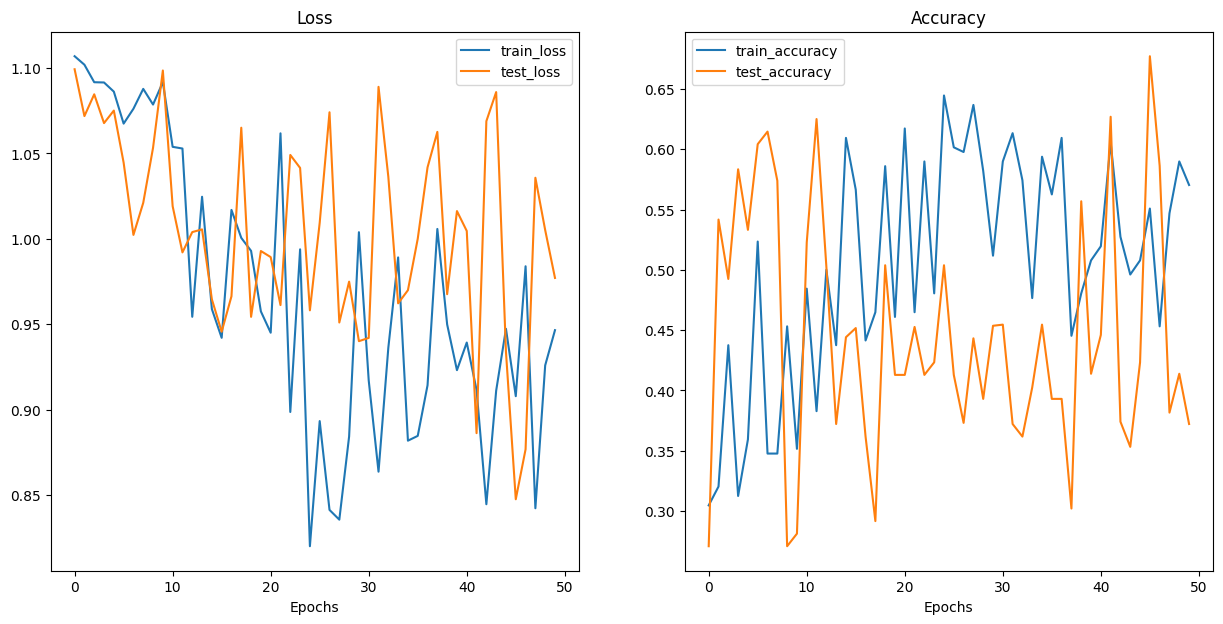

In [75]:
plot_loss_curves(results=model_1_results)

## 10. Compare the model results

After evaluatin our modelling experiments on their own, it's important to compare them to each other.

There's a few different ways to do this:
1. Hard coding (what we're doing)
2. PyTorch + Tensorboard
3. Weights & Biases
4. MLFlow

In [76]:
# Create the dataframes from the model results
import pandas as pd

model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

In [77]:
model_0_df

train_loss  train_acc  test_loss  test_acc
0     1.106319   0.304688   1.095579  0.449219
1     1.099806   0.328125   1.083025  0.402344
2     1.086854   0.488281   1.079709  0.433594
3     1.084233   0.398438   1.057177  0.546875
4     1.066216   0.414062   1.039538  0.445312
5     1.030505   0.433594   0.983543  0.546875
6     0.985437   0.421875   0.916986  0.527344
7     0.966291   0.578125   0.888085  0.527344
8     0.923817   0.597656   0.890886  0.496094
9     0.996901   0.464844   0.876114  0.601562
10    0.869879   0.519531   0.843376  0.640625
11    0.924058   0.460938   0.800186  0.640625
12    0.784104   0.632812   0.791159  0.628906
13    0.904503   0.523438   0.784558  0.699219
14    0.789142   0.695312   0.734988  0.683594
15    0.749281   0.679688   0.722210  0.703125
16    0.773371   0.699219   0.717470  0.691406
17    0.748017   0.656250   0.709380  0.687500
18    0.774962   0.707031   0.694582  0.691406
19    0.775545   0.636719   0.695016  0.699219
20    0.784447   0.617188   0.720125  0.742188
21    0.786967   0.601562   0.686890  0.687500
22    0.732279   0.652344   0.677057  0.687500
23    0.869913   0.570312   0.665612  0.730469
24    0.653157   0.734375   0.654107  0.742188
25    0.704429   0.750000   0.639086  0.761719
26    0.631557   0.738281   0.635443  0.718750
27    0.656035   0.714844   0.605496  0.746094
28    0.601447   0.757812   0.596253  0.753906
29    0.765534   0.632812   0.588524  0.785156
30    0.660660   0.792969   0.602845  0.792969
31    0.574362   0.781250   0.558820  0.792969
32    0.575708   0.789062   0.556618  0.746094
33    0.570917   0.773438   0.529412  0.789062
34    0.554701   0.792969   0.543979  0.761719
35    0.570336   0.750000   0.530325  0.781250
36    0.594603   0.765625   0.540246  0.757812
37    0.646706   0.742188   0.496072  0.812500
38    0.672200   0.742188   0.470473  0.816406
39    0.582575   0.765625   0.477001  0.777344
40    0.702390   0.656250   0.454519  0.820312
41    0.626574   0.679688   0.504255  0.757812
42    0.658296   0.765625   0.544124  0.824219
43    0.648546   0.648438   0.504837  0.781250
44    0.704490   0.679688   0.513817  0.777344
45    0.689137   0.675781   0.504825  0.792969
46    0.599249   0.781250   0.462061  0.835938
47    0.708121   0.691406   0.467158  0.832031
48    0.492626   0.851562   0.459355  0.863281
49    0.511447   0.859375   0.482376  0.812500

In [78]:
model_1_df

train_loss  train_acc  test_loss  test_acc
0     1.106914   0.304688   1.099288  0.270833
1     1.101936   0.320312   1.071888  0.541667
2     1.091699   0.437500   1.084630  0.492424
3     1.091548   0.312500   1.067778  0.583333
4     1.086191   0.359375   1.075107  0.533144
5     1.067476   0.523438   1.044618  0.604167
6     1.076172   0.347656   1.002341  0.614583
7     1.087800   0.347656   1.021133  0.573864
8     1.078631   0.453125   1.053323  0.270833
9     1.091757   0.351562   1.098560  0.281250
10    1.053887   0.484375   1.019128  0.522727
11    1.052899   0.382812   0.992114  0.625000
12    0.954428   0.500000   1.004001  0.502841
13    1.024673   0.437500   1.005570  0.372159
14    0.958964   0.609375   0.964665  0.444129
15    0.942116   0.566406   0.945684  0.451705
16    1.016977   0.441406   0.966430  0.361742
17    1.000608   0.464844   1.065079  0.291667
18    0.992995   0.585938   0.954401  0.503788
19    0.957581   0.460938   0.992917  0.412879
20    0.945111   0.617188   0.989361  0.412879
21    1.061795   0.464844   0.961284  0.452652
22    0.898722   0.589844   1.049138  0.412879
23    0.993901   0.480469   1.041551  0.423295
24    0.820161   0.644531   0.958213  0.503788
25    0.893394   0.601562   1.009488  0.412879
26    0.841418   0.597656   1.074115  0.373106
27    0.835710   0.636719   0.951093  0.443182
28    0.884378   0.582031   0.975003  0.392992
29    1.003932   0.511719   0.940164  0.453598
30    0.917157   0.589844   0.942057  0.454545
31    0.863780   0.613281   1.088999  0.372159
32    0.936309   0.574219   1.036344  0.361742
33    0.989180   0.476562   0.962294  0.402462
34    0.881927   0.593750   0.969992  0.454545
35    0.884735   0.562500   1.000090  0.392992
36    0.914364   0.609375   1.041887  0.392992
37    1.005832   0.445312   1.062618  0.302083
38    0.949952   0.480469   0.967652  0.556818
39    0.923198   0.507812   1.016284  0.413826
40    0.939356   0.519531   1.004658  0.446023
41    0.911611   0.605469   0.886330  0.626894
42    0.844733   0.527344   1.068908  0.374053
43    0.911198   0.496094   1.085943  0.353220
44    0.947385   0.507812   0.933870  0.423295
45    0.907964   0.550781   0.847646  0.677083
46    0.983993   0.453125   0.876864  0.586174
47    0.842379   0.546875   1.035786  0.381629
48    0.925998   0.589844   1.005181  0.413826
49    0.946601   0.570312   0.977157  0.372159

And now we can write some plotting code using `matplotlib` to visualize the results of `model_0` and `model_1` together.

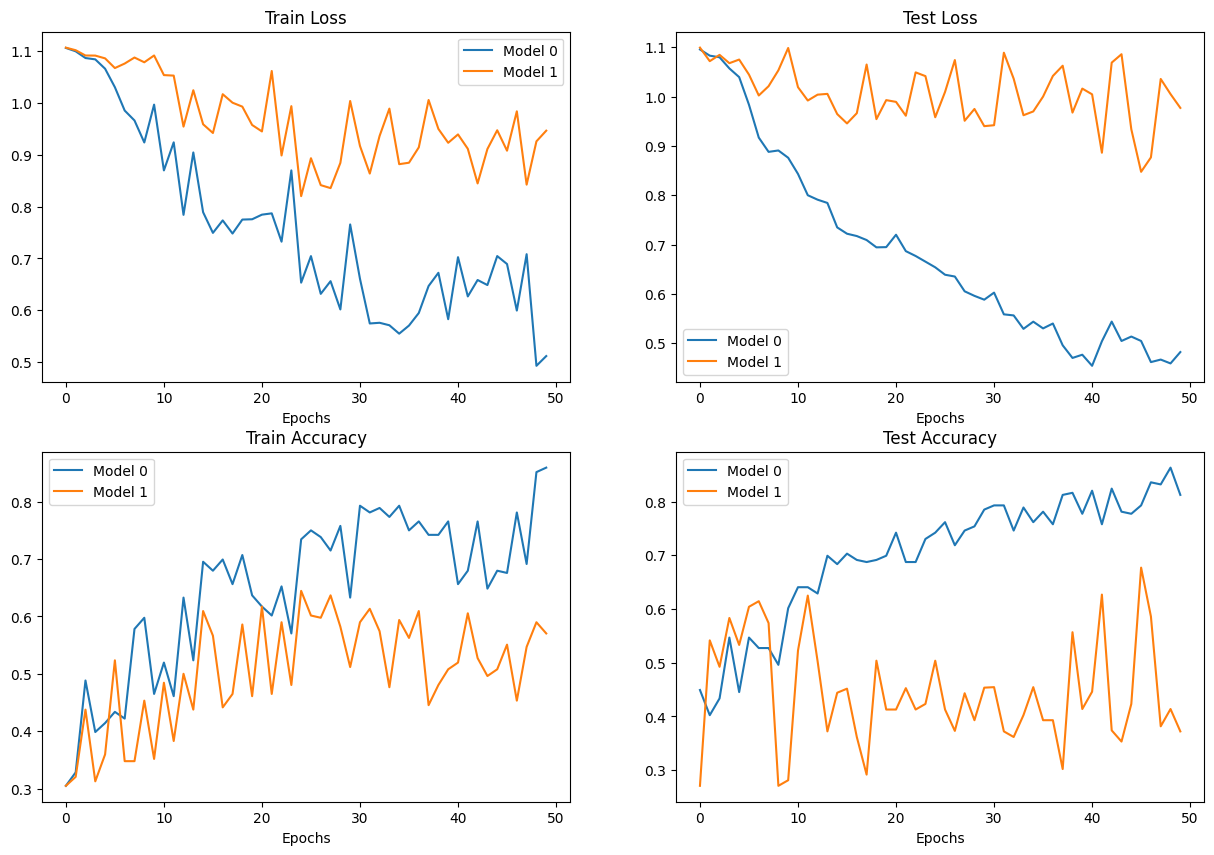

In [79]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot the train loss
plt.subplot(2, 2, 1) # rows, cols, plot_count (index) ---> 2x2 = 4 plot count (1, 2, 3, 4)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot the test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot the train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot the test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()


## 11. Making a prediction on a custom image

Although we've trained a model on custom data... how to you make a prediction on a sample/image that's not in either training or testing dataset.

In [80]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-data.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GIthHub, need to use the "raw" file link
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/04-pizza-dad.jpeg?raw=true")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download...")

### 11.1 Loading in a custom image with PyTorch

We have to make sure our custom imaghe is in the same format as the data our model was trained on.

* In tensor form with datatype (torch.float32)
* Of shape 64x64x3
* On the right device

In [81]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
print(f"Custom image tensor:\n {custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image datatype: {custom_image_uint8.dtype}")

Custom image tensor:
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 4032, 3024])
Custom image data

(-0.5, 3023.5, 4031.5, -0.5)

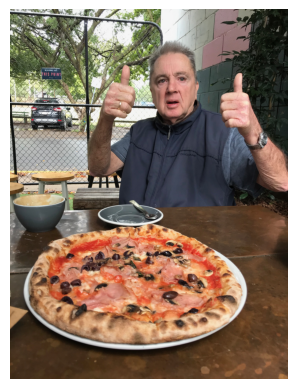

In [82]:
plt.imshow(custom_image_uint8.permute(1, 2, 0))
plt.axis(False)

### 11.2 Making a prediction on a custom image with a trained PyTorch model

In [83]:
# Try to make a prediction on an image in uint8 format
# model_1.eval()
# with torch.inference_mode():
#     model_1(custom_image_uint8.to(device))

In [84]:
# Load in the custom image and conver to torch.float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255
custom_image, custom_image.dtype

(tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
          [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
          [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
          ...,
          [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
          [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
          [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],
 
         [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
          [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
          [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
          ...,
          [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
          [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
          [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],
 
         [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
          [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
          [0.3412, 0.4353, 0.5333,  ...,

In [85]:
# Try to make a prediction on an image in uint8 format
# model_1.eval()
# with torch.inference_mode():
#     model_1(custom_image.to(device))

(-0.5, 3023.5, 4031.5, -0.5)

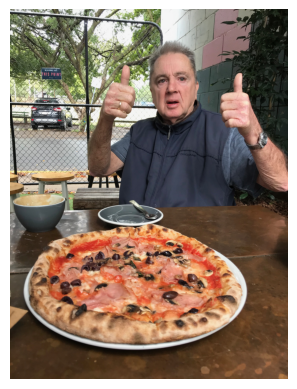

In [86]:
plt.imshow(custom_image.permute(1, 2, 0))
plt.axis(False)

In [87]:
# Create transform pipeline to resize image
from torchvision import transforms

custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    # transforms.ToTensor()
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out the shapes
print(f"Original shape: {custom_image.shape}")
print(f"Tranformed shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
Tranformed shape: torch.Size([3, 64, 64])


(-0.5, 63.5, 63.5, -0.5)

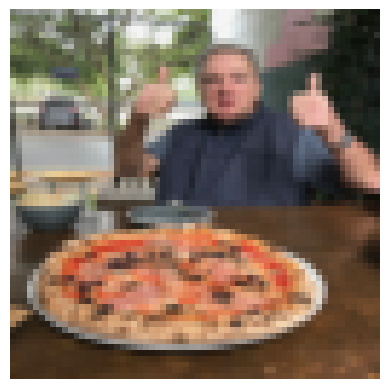

In [88]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))
plt.axis(False)

In [89]:
# This will error: image not on right device
# model_1.eval()
# with torch.inference_mode():
#     custom_image_pred = model_1(custom_image_transformed)

In [90]:
# This will error: no batch size
# model_1.eval()
# with torch.inference_mode():
#     custom_image_pred = model_1(custom_image_transformed.to(device))

In [91]:
custom_image_transformed.shape, custom_image_transformed.unsqueeze(dim=0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [92]:
# This should work - added a batch size
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

custom_image_pred

tensor([[ 0.1713, -0.4745, -0.4271]])

Note, to make a prediction on a custom image we had to:

* Load the image and turn it into tensor
* Make sure the image was the same datatype as the model (torch.float32)
* Make sure the image was the same shape as the data the model was trained on (3, 64, 64) with a batch size... (1, 3, 64, 64)
* Make usre the image was on the same device as our model

In [93]:
# Convert logits -> prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.4822, 0.2528, 0.2651]])

In [94]:
# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1).cpu()
custom_image_pred_label

tensor([0])

In [95]:
class_names[custom_image_pred_label]

'pizza'

### 11.3 Putting custom image prediction together: building a function

Ideal outcome:

A function where we pass an image path to and have our model predict on that image and plot image + prediction

In [96]:
def predict_and_plot_image(model: torch.nn.Module,
                           image_path: str,
                           class_names: List[str]=None,
                           transform: torchvision.transforms=None,
                           device: torch.device=device):
    """Makes a prediction on a target image with trained model and plots the image and prediction."""

    # Load the image and convert to tensor values to float32
    target_image = torchvision.io.read_image(image_path).type(torch.float32)

    # Divide the image pixel values by 2555 to get them betweeen [0, 1]
    target_image = target_image / 255

    # Transform if necessary
    if transform:
        target_image = transform(target_image)

    # Make sure the model is on the target device
    model.to(device)

    # Pass the image to the model for prediction
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # Convert the logits to prediction probabilities
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    print(target_image_pred_probs)

    # Convert the preidction probabilities to the prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)



    # Plot the image with prediction label
    plt.imshow(custom_image_transformed.permute(1, 2, 0))
    if class_names:
        # Get the prediction name
        prediction = class_names[custom_image_pred_label.cpu()]

        title = f"Pred: {prediction} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"

    plt.title(title)
    plt.axis(False)

tensor([[0.4872, 0.2310, 0.2819]])


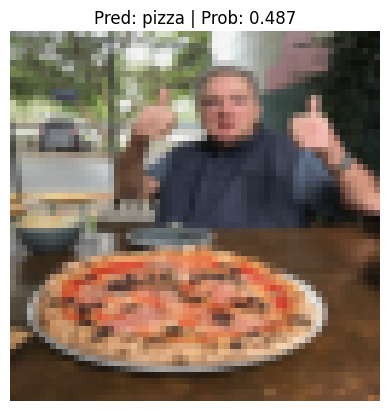

In [98]:
predict_and_plot_image(model=model_0,
                       image_path=str(custom_image_path),
                       class_names=class_names,
                       transform=custom_image_transform,
                       device=device)